In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict

%matplotlib inline

In [2]:
class SGD:
    def __init__(self,lr=0.01):
        self.lr = lr
    
    def update(self,params,grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [3]:
class Momentum:
    def __init__(self,lr=0.01,momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self,params,grads):
        if self.v is None:
            self.v = {}
            for key,val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key]-self.lr*grads[key]
            params[key] += self.v[key]

In [4]:
class AdaGrad:
    def __init__(self,lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self,params,grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key])+1e-7)


In [23]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(0,x)

In [32]:
def test_initial_weight(w="xavier",h=sigmoid):
    x = np.random.randn(1000,100)
    node_num = 100
    hidden_layer_size = 5
    activations = {}
    
    if w == "xavier":
        w = 1/np.sqrt(node_num)
    elif w == "he":
        w = np.sqrt(2.0/node_num)

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        w = np.random.randn(node_num,node_num)*w

        z = np.dot(x,w)
        a = h(z)

        activations[i] = a

    for i,a in activations.items():
        plt.subplot(1,len(activations),i+1)
        plt.title(str(i+1)+"-layer")
        plt.hist(a.flatten(),30,range=(0,1))

    plt.show()

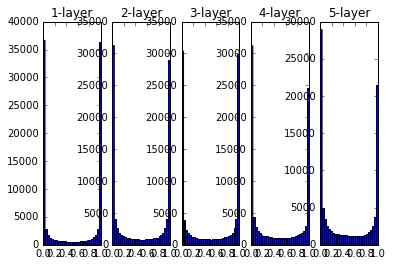

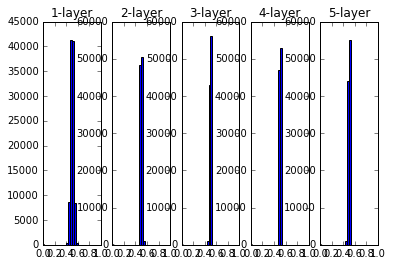

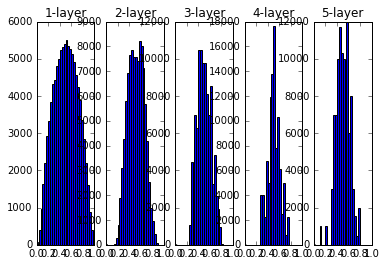

In [30]:
test_initial_weight(1,h=sigmoid)
test_initial_weight(0.01,h=sigmoid)
test_initial_weight(w="xavier",h=sigmoid)

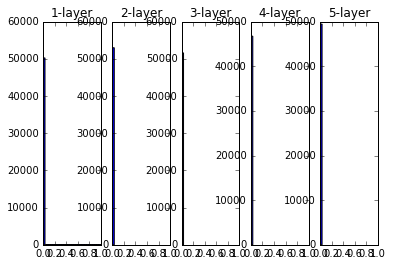

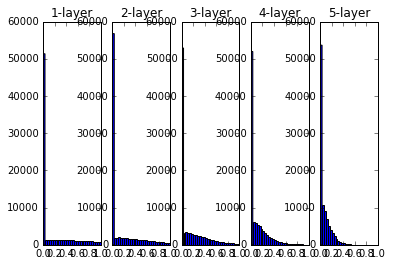

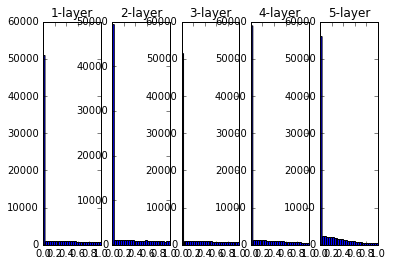

In [33]:
test_initial_weight(1,h=relu)
test_initial_weight(w="xavier",h=relu)
test_initial_weight(w="he",h=relu)

In [36]:
class BatchNormalization:
    def __init__(self,gamma,beta,momentum=0.9,running_mean = None,running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None
        
        self.running_mean = running_mean
        self.running_var = running_var
        
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None
    
    def forward(self,x,train_flag = True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N,C,H,W=x.shape
            x = x.reshape(N,-1)
        out = self.__forward(x,train_flag)
        return out.reshape(*self.input_shape)
    
    def __forward(self,x,train_flag):
        if self.running_mean is None:
            N,D = x.shape
            self.rnning_mean = np.zeros(D)
            self.running_var = np.zeros(D)
        
        if train_flag:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2,axis=0)
            std = np.sqrt(var + 1e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self,running_mean * ( 1- self.momentum ) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum)*var
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var+1e-7)))
        
        out = self.gamma * xn + beta
        return out
    
    def backward(self,dout):
        if dout.ndim != 2:
            N,C,H,W = dout.shape
            dout = dout.reshape(N,-1)
        
        dx = self.__backward(dout)
        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self,dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout,axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dmu = np.sum(dxc,axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    

In [37]:
class Dropout:
    def __init__(self,dropout_rate = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self,x,train_flag=True):
        if train_flag:
            self.mask = np.randon.rand(*x.shape) > self.dropout_ratio
            return x*self.mask
        else:
            return x * (1-self.dropout_ratio)
    
    def backward(self,dout):
        return dout * self.mask